In [1]:
from typing import Callable, Sequence
import brainstate as bst
import braintools as bts
import brainunit as bu
import jax
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import dendritex as dx
from dendritex import IonInfo
import golgi_mophology

bst.environ.set(dt=0.001 * bu.ms)
s = bu.mS / (bu.cm ** 2)

In [2]:
## morphology params
loaded_params = np.load('golgi_morphology.npz')

connection = loaded_params['connection']
L = loaded_params['L']               # um
diam = loaded_params['diam']         # um
Ra = loaded_params['Ra']             # ohm * cm
cm = loaded_params['cm']             # uF / cm ** 2

n_neuron = 1
n_compartments = len(L)
size = (n_neuron,n_compartments)

index_soma = loaded_params['index_soma']
index_axon = loaded_params['index_axon']
index_dend_basal = loaded_params['index_dend_basal']
index_dend_apical = loaded_params['index_dend_apical']

## test ion 

In [3]:
connection = ((1,2),(2,3))

In [9]:
gl = np.zeros(n_compartments) 
gh =  np.zeros(n_compartments) 
gh[index_soma] = 15.

In [5]:
class Golgi(dx.neurons.MultiCompartment):
  def __init__(self, size , connection, Ra, cm, diam, L, gl, gh):
    super().__init__(
      size = size,
      connection = connection,
      Ra = Ra * bu.ohm * bu.cm,
      cm = cm * bu.uF / bu.cm ** 2,
      diam = diam * bu.um,
      L = L * bu.um,
      V_th = 20. * bu.mV,
      V_initializer = bst.init.Constant(-55 * bu.mV),
      spk_fun = bst.surrogate.ReluGrad(),
    )

    self.IL = dx.channels.IL(self.size, E = -55. * bu.mV, g_max = gl*s )
    #self.Ih1 = dx.channels.Ih2_Ma2020(self.size, E = -20. * bu.mV, g_max = gh*s )
    self.ca = dx.ions.SodiumFixed(self.size, E = 130.* bu.mV , C = 5e-5 *bu.mM )
    self.ca.add_elem(dx.channels.ICav31_Ma2020(self.size, g_max = gh*s ))
   
  def step_run(self, t, inp):
    dx.rk4_step(self, t, inp)
    return self.V.value, self.spike.value

In [6]:
from functools import partial

#static_args = np.arange(1, 9)
#@partial(jax.jit, static_argnums=static_args)
#@jax.jit
def simulate(currents, size , connection, Ra, cm, diam, L, gl, gkv11):
  cell = Golgi(size , connection, Ra, cm, diam, L, gl, gkv11)
  cell.init_state()
  cell.reset_state()

  times = np.arange(0, currents.shape[0]) * bst.environ.get_dt()
  vs, spks = bst.transform.for_loop(cell.step_run, times, currents)
  
  return vs, spks 


In [7]:
def visualize_a_simulate(currents, size ,connection, Ra, cm, diam, L, gl, gkv11):
  times = np.arange(0, currents.shape[0]) * bst.environ.get_dt()
  vs, spks = simulate(currents, size ,connection, Ra, cm, diam, L, gl, gkv11)

  fig, gs = bts.visualize.get_figure(1, 1, 3.0, 4.0)
  ax = fig.add_subplot(gs[0, 0])
  plt.plot(times / bu.ms, bu.math.squeeze(vs / bu.mV))
  plt.xlabel('Time [ms]')
  plt.ylabel('Potential [mV]')
  plt.show()

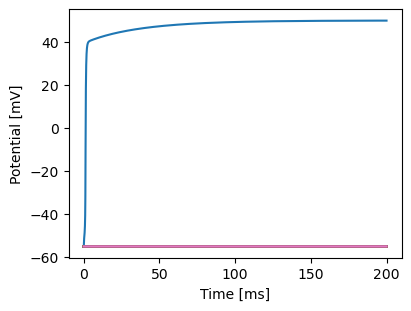

In [10]:
n_batch, n_seq =1, 200000
inp_traces = np.full((n_batch, n_seq, n_compartments), 0.) * bu.nA
inp_traces[...,0] =0.00  * bu.nA
inp_traces[:,int(n_seq/2):,:] =0.00  * bu.nA
visualize_a_simulate(inp_traces[0], size , connection, Ra, cm, diam, L, gl, gh)

In [9]:
E = (1e-3) * -55*bu.mV
zeta = (2 * bu.faraday_constant * E )/( bu.gas_constant  * (273.15 + 22) * bu.kelvin)
zeta.to_decimal()



Array(-0.00432491, dtype=float32)

In [ ]:
a = -55 * bu.mV
b=a / bu.mV
b

In [ ]:
## conductvalues 
conductvalues = 1e3 * np.array([
    0.00499506303209, 0.01016375552607, 0.00247172479141, 0.00128859564935, 
    3.690771983E-05, 0.0080938853146, 0.01226052748146, 0.01650689958385, 
    0.00139885617712, 0.14927733727426, 0.00549507510519, 0.14910988921938, 
    0.00406420380423, 0.01764345789036, 0.10177335775222, 0.0087689418803, 
    3.407734319E-05, 0.0003371456442, 0.00030643090764, 0.17233663543619, 
    0.00024381226198, 0.10008178886943, 0.00595046001148, 0.0115, 0.0091
])


## IL params
gl =  np.ones(n_compartments) 
gl[index_soma] = 0.03  
gl[index_axon] = 0.001  
gl[index_axon[0]] = 0.03
gl[index_dend_basal] = 0.03
gl[index_dend_apical] = 0.03   


## Kv11 params
gkv11 =  np.zeros(n_compartments) 
gkv11[index_soma] = conductvalues[10] 

## Kv34 params 
gkv34 =  np.zeros(n_compartments) 
gkv34[index_soma] = conductvalues[11]
gkv34[index_axon[1:]] = 9.1

## Kv43 params 
gkv43 =  np.zeros(n_compartments) 
gkv43[index_soma] = conductvalues[12]


In [ ]:
class Golgi(dx.neurons.MultiCompartment):
  def __init__(self, size , connection, Ra, cm, diam, L, gl, gkv11):
    super().__init__(
      size = size,
      connection = connection,
      Ra = Ra * bu.ohm * bu.cm,
      cm = cm * bu.uF / bu.cm ** 2,
      diam = diam * bu.um,
      L = L * bu.um,
      V_th = 20. * bu.mV,
      V_initializer = bst.init.Constant(-55 * bu.mV),
      spk_fun = bst.surrogate.ReluGrad(),
    )

    self.IL = dx.channels.IL(self.size, E = -55. * bu.mV, g_max = gl*s )
    self.k = dx.ions.PotassiumFixed(self.size, E = -80.* bu.mV)
    self.k.add_elem(dx.channels.IKv11_Ak2007(self.size, g_max = gkv11*s ))
   
  def step_run(self, t, inp):
    dx.rk4_step(self, t, inp)
    return self.V.value, self.spike.value

In [ ]:
from functools import partial

#static_args = np.arange(1, 9)
#@partial(jax.jit, static_argnums=static_args)
#@jax.jit
def simulate(currents, size , connection, Ra, cm, diam, L, gl, gkv11):
  cell = Golgi(size , connection, Ra, cm, diam, L, gl, gkv11)
  cell.init_state()
  cell.reset_state()

  times = np.arange(0, currents.shape[0]) * bst.environ.get_dt()
  vs, spks = bst.transform.for_loop(cell.step_run, times, currents)
  
  return vs, spks 


In [ ]:
def visualize_a_simulate(currents, size ,connection, Ra, cm, diam, L, gl, gkv11):
  times = np.arange(0, currents.shape[0]) * bst.environ.get_dt()
  vs, spks = simulate(currents, size ,connection, Ra, cm, diam, L, gl, gkv11)

  fig, gs = bts.visualize.get_figure(1, 1, 3.0, 4.0)
  ax = fig.add_subplot(gs[0, 0])
  plt.plot(times / bu.ms, bu.math.squeeze(vs / bu.mV))
  plt.xlabel('Time [ms]')
  plt.ylabel('Potential [mV]')
  plt.show()

In [ ]:
n_batch, n_seq =1, 200000
inp_traces = np.full((n_batch, n_seq, n_compartments), 0.) * bu.nA
inp_traces[...,0] =0.00  * bu.nA
inp_traces[:,int(n_seq/2):,:] =0.00  * bu.nA
visualize_a_simulate(inp_traces[0], size , connection, Ra, cm, diam, L, gl, gkv11)